In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import ignite.metrics
import ignite.contrib.handlers
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import librosa.display as ld
import pandas as pd
import noisereduce as nr
import soundfile as sf
import math
import pickle

from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Init

In [2]:
IMAGE_SIZE = 64
NUM_CLASSES = 36 # 26 + 10
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-1
EPOCHS = 1100

In [3]:
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE:", DEVICE)

DEVICE: mps


### Pre-processing

In [4]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [5]:
def convert_to_df(AUDIO_FILE, keys, labels, data_dict):
    for i, File in tqdm(enumerate(keys)):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0

    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)

    return df, sample_rate 

In [6]:
AUDIO_FILE = '../Keystroke-Datasets/Zoom/'

keys_s = '1234567890qwertyuiopasdfghjklzxcvbnm'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}
data_frame, sr = convert_to_df(AUDIO_FILE, keys, labels, data_dict)

36it [00:02, 17.91it/s]


In [7]:
print("Sample Rate --> \n", sr)
print("-"*50)
print("data_frame.head() --> \n", data_frame.head())
print("-"*50)
print("data_frame.info() --> \n", data_frame.info())

Sample Rate --> 
 32000
--------------------------------------------------
data_frame.head() --> 
   Key                                               File
0   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
1   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
2   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
3   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
4   0  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
data_frame.info() --> 
 None


### Start Training

In [8]:
train, tmp = train_test_split(data_frame, test_size=0.2)
val, test = train_test_split(tmp, test_size=0.5)

print(len(train))
print(len(val))
print(len(test))

720
90
90


In [9]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])

In [10]:
train_set = MyDataset(train, aug = aug)
val_set   = MyDataset(val,   transform = transform)
test_set  = MyDataset(test,  transform = transform)

### Model

In [11]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [12]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [13]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [14]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [15]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [16]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [17]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [19]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [20]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=26):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [21]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D
model = MyCoAtNet(nums_blocks, channels)

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
# Taken from MyCoAtNet
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [23]:
model.apply(init_linear)
model.to("cpu")

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
summary(model, input_size=(1, 64, 64))
model.to(DEVICE)

Number of parameters: 24,025,606
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

### Training

In [24]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [25]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [26]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [27]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [28]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 8.852764129638672, Accuracy: 0.043055555555555555 Correct: 31 Total: 720 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.1 Validation loss: 17.146671295166016 Correct: 9 Total: 90
Epoch [2/1100], Loss: 10.069875717163086, Accuracy: 0.06805555555555555 Correct: 49 Total: 720 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.05555555555555555 Validation loss: 12.300509452819824 Correct: 5 Total: 90
Epoch [3/1100], Loss: 14.912328720092773, Accuracy: 0.08194444444444444 Correct: 59 Total: 720 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.1 Validation loss: 20.830333709716797 Correct: 9 Total: 90
Epoch [4/1100], Loss: 11.365888595581055, Accuracy: 0.11666666666666667 Correct: 84 Total: 720 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.1111111111111111 Validation loss: 5.990129470825195 Correct: 10 Total: 90
Epoch [5/1100], Loss: 5.1240997314453125, Accuracy: 0.08333333333333333 Co

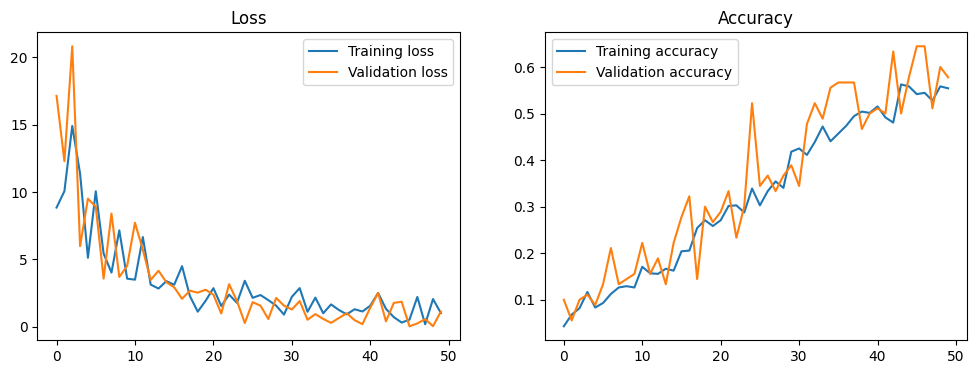

Epoch [51/1100], Loss: 0.7743351459503174, Accuracy: 0.5680555555555555 Correct: 409 Total: 720 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.6111111111111112 Validation loss: 0.031230982393026352 Correct: 55 Total: 90
Epoch [52/1100], Loss: 0.24529321491718292, Accuracy: 0.5611111111111111 Correct: 404 Total: 720 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.6 Validation loss: 0.43117958307266235 Correct: 54 Total: 90
Epoch [53/1100], Loss: 0.32923054695129395, Accuracy: 0.5902777777777778 Correct: 425 Total: 720 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.6111111111111112 Validation loss: 0.7410279512405396 Correct: 55 Total: 90
Epoch [54/1100], Loss: 1.0950322151184082, Accuracy: 0.575 Correct: 414 Total: 720 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.5777777777777777 Validation loss: 0.486471027135849 Correct: 52 Total: 90
Epoch [55/1100], Loss: 2.9262964725494385,

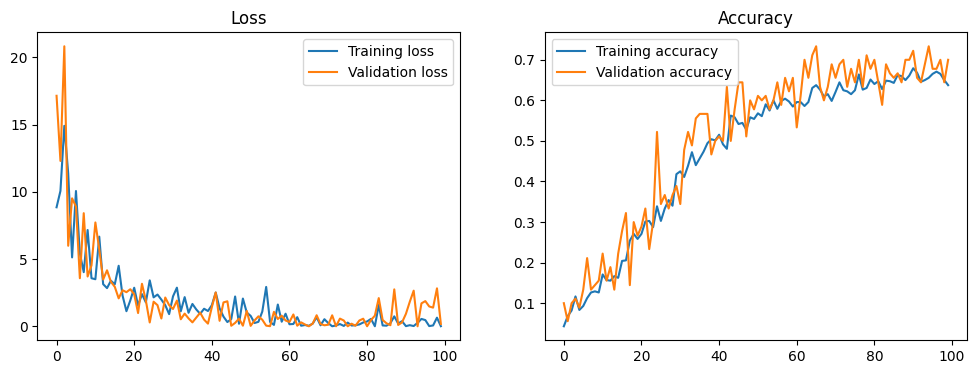

Epoch [101/1100], Loss: 0.20678818225860596, Accuracy: 0.6708333333333333 Correct: 483 Total: 720 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.6777777777777778 Validation loss: 1.1062538623809814 Correct: 61 Total: 90
Epoch [102/1100], Loss: 0.1967235654592514, Accuracy: 0.6611111111111111 Correct: 476 Total: 720 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.6333333333333333 Validation loss: 1.4588502645492554 Correct: 57 Total: 90
Epoch [103/1100], Loss: 0.07848367840051651, Accuracy: 0.6541666666666667 Correct: 471 Total: 720 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.7 Validation loss: 1.5497195704483602e-07 Correct: 63 Total: 90
Epoch [104/1100], Loss: 0.5069536566734314, Accuracy: 0.6583333333333333 Correct: 474 Total: 720 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.6888888888888889 Validation loss: 7.457406172761694e-05 Correct: 62 Total: 90
Epoch [105/1100], L

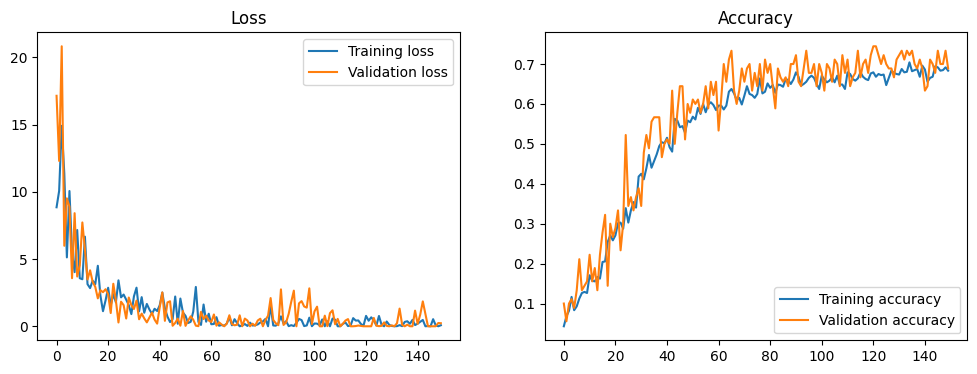

Epoch [151/1100], Loss: 0.15352392196655273, Accuracy: 0.675 Correct: 486 Total: 720 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.6444444444444445 Validation loss: 0.8439359664916992 Correct: 58 Total: 90
Epoch [152/1100], Loss: 0.0001621564879314974, Accuracy: 0.6875 Correct: 495 Total: 720 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.7 Validation loss: 0.004493981134146452 Correct: 63 Total: 90
Epoch [153/1100], Loss: 0.3476532995700836, Accuracy: 0.6875 Correct: 495 Total: 720 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.6888888888888889 Validation loss: 0.03926300257444382 Correct: 62 Total: 90
Epoch [154/1100], Loss: 0.5097790360450745, Accuracy: 0.6888888888888889 Correct: 496 Total: 720 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.7111111111111111 Validation loss: 0.00027410389157012105 Correct: 64 Total: 90
Epoch [155/1100], Loss: 0.03751685097813606, Accuracy: 

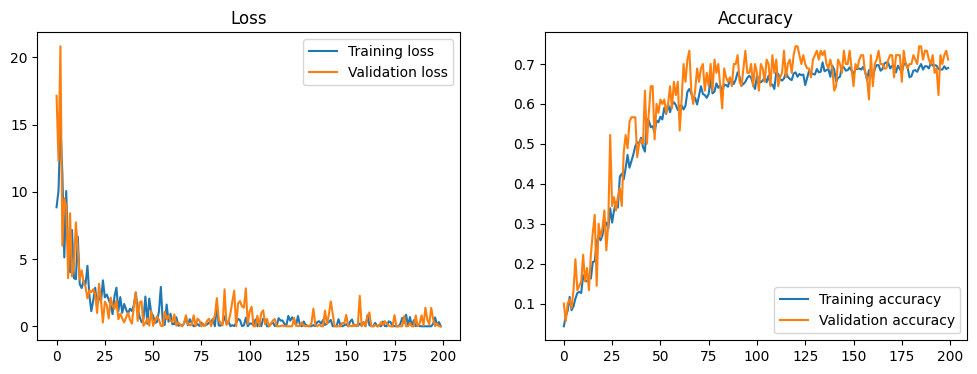

Epoch [201/1100], Loss: 0.5611638426780701, Accuracy: 0.7027777777777777 Correct: 506 Total: 720 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.7111111111111111 Validation loss: 1.022593379020691 Correct: 64 Total: 90
Epoch [202/1100], Loss: 1.0301635265350342, Accuracy: 0.6972222222222222 Correct: 502 Total: 720 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.7555555555555555 Validation loss: 0.04252554848790169 Correct: 68 Total: 90
Epoch [203/1100], Loss: 0.9780572652816772, Accuracy: 0.6944444444444444 Correct: 500 Total: 720 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.7444444444444445 Validation loss: 2.7298558507027337e-06 Correct: 67 Total: 90
Epoch [204/1100], Loss: 0.002445736899971962, Accuracy: 0.6902777777777778 Correct: 497 Total: 720 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.7333333333333333 Validation loss: 0.9706236124038696 Correct: 66 Total: 90
Epoch 

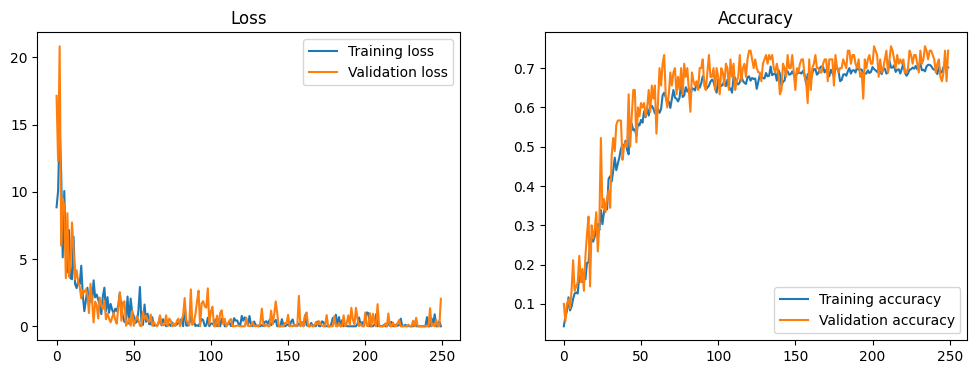

Epoch [251/1100], Loss: 0.003507118672132492, Accuracy: 0.7138888888888889 Correct: 514 Total: 720 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.6888888888888889 Validation loss: 0.014198986813426018 Correct: 62 Total: 90
Epoch [252/1100], Loss: 0.1352037787437439, Accuracy: 0.6902777777777778 Correct: 497 Total: 720 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.7666666666666667 Validation loss: 2.1457648813338892e-07 Correct: 69 Total: 90
Epoch [253/1100], Loss: 1.7061720427591354e-06, Accuracy: 0.6958333333333333 Correct: 501 Total: 720 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.7444444444444445 Validation loss: 0.0 Correct: 67 Total: 90
Epoch [254/1100], Loss: 5.885948439754429e-07, Accuracy: 0.7069444444444445 Correct: 509 Total: 720 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.7333333333333333 Validation loss: 0.06035327911376953 Correct: 66 Total: 90
Epoch [255/

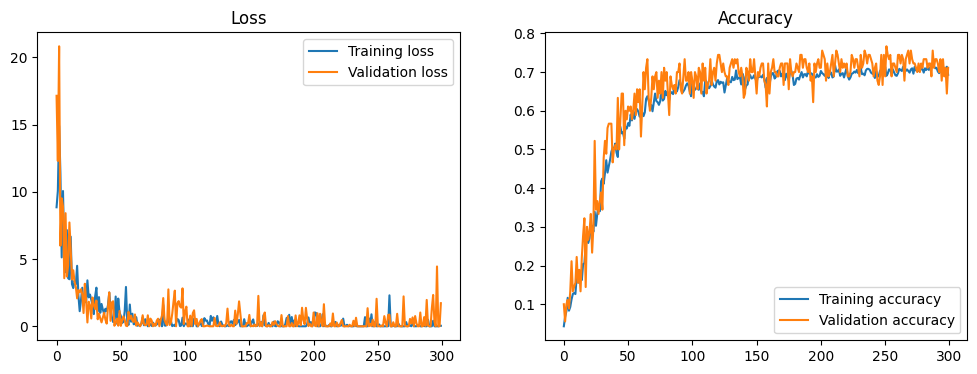

Epoch [301/1100], Loss: 1.564621072702721e-07, Accuracy: 0.7111111111111111 Correct: 512 Total: 720 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.7 Validation loss: 0.18803146481513977 Correct: 63 Total: 90
Epoch [302/1100], Loss: 1.2722755670547485, Accuracy: 0.7125 Correct: 513 Total: 720 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.6666666666666666 Validation loss: 3.5697319507598877 Correct: 60 Total: 90
Epoch [303/1100], Loss: 2.548049224060378e-06, Accuracy: 0.7069444444444445 Correct: 509 Total: 720 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.7111111111111111 Validation loss: 0.938388466835022 Correct: 64 Total: 90
Epoch [304/1100], Loss: 0.12299707531929016, Accuracy: 0.7041666666666667 Correct: 507 Total: 720 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.6888888888888889 Validation loss: 0.01001477986574173 Correct: 62 Total: 90
Epoch [305/1100], Loss: 1.49011

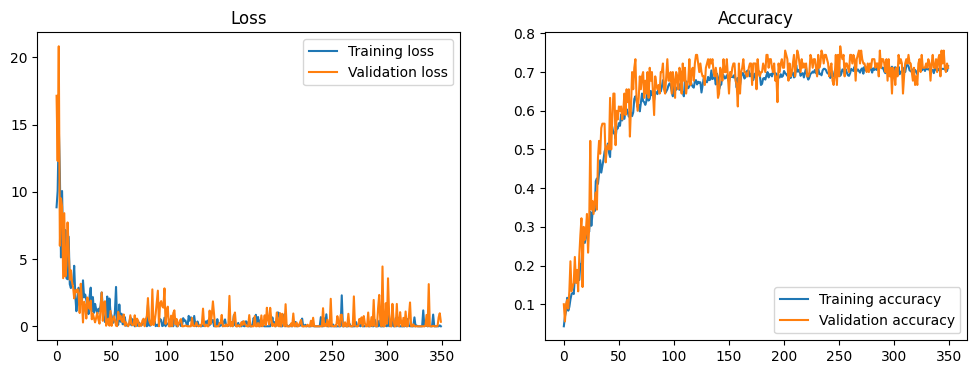

Epoch [351/1100], Loss: 1.1175862368872913e-07, Accuracy: 0.7180555555555556 Correct: 517 Total: 720 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.7111111111111111 Validation loss: 0.0548635832965374 Correct: 64 Total: 90
Epoch [352/1100], Loss: 4.4703469370688254e-08, Accuracy: 0.7138888888888889 Correct: 514 Total: 720 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.7111111111111111 Validation loss: 0.3033255636692047 Correct: 64 Total: 90
Epoch [353/1100], Loss: 0.04340652748942375, Accuracy: 0.7083333333333334 Correct: 510 Total: 720 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.6888888888888889 Validation loss: 1.220048427581787 Correct: 62 Total: 90
Epoch [354/1100], Loss: 0.001206382643431425, Accuracy: 0.7097222222222223 Correct: 511 Total: 720 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.7333333333333333 Validation loss: 1.5979348421096802 Correct: 66 Total: 90
Epoch

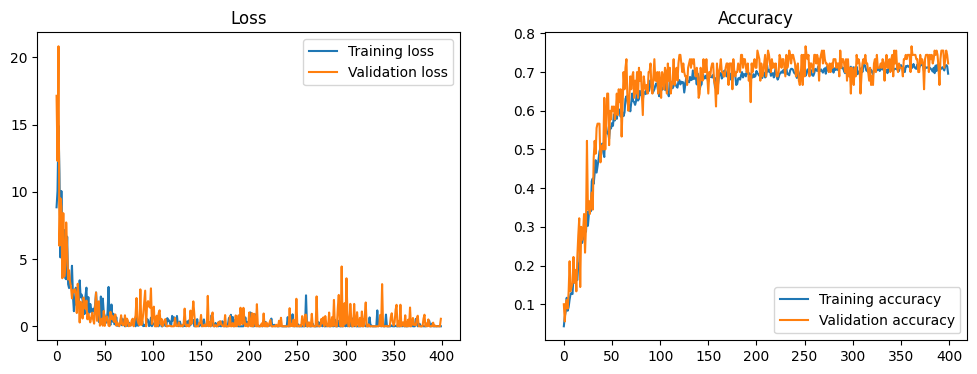

Epoch [401/1100], Loss: 4.7056797484401613e-05, Accuracy: 0.7166666666666667 Correct: 516 Total: 720 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.7111111111111111 Validation loss: 0.7394731044769287 Correct: 64 Total: 90
Epoch [402/1100], Loss: 1.9018438251805492e-05, Accuracy: 0.7166666666666667 Correct: 516 Total: 720 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.7 Validation loss: 0.00012207876716274768 Correct: 63 Total: 90
Epoch [403/1100], Loss: 1.4901095255481778e-06, Accuracy: 0.7083333333333334 Correct: 510 Total: 720 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.7333333333333333 Validation loss: 0.00022808524954598397 Correct: 66 Total: 90
Epoch [404/1100], Loss: 8.270090461337531e-07, Accuracy: 0.7138888888888889 Correct: 514 Total: 720 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.7111111111111111 Validation loss: 1.680839886830654e-06 Correct: 64 Total: 90
E

KeyboardInterrupt: 

In [29]:
best_model_path = "CoAtNet_36_Zoom_Best.pkl"
model_path = "CoAtNet_36_Zoom.pkl"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(DEVICE)
            labels = torch.squeeze(labels).to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(DEVICE)
                labels = torch.squeeze(labels).to(DEVICE)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)